In [1]:
import os
import cv2
import ujson
from skimage.transform import rotate
import numpy as np
from torch.utils.data import Dataset
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
from pathlib import Path
from config import GlobalConfig

from utils import get_vehicle_to_virtual_lidar_transform, \
      get_vehicle_to_lidar_transform, get_lidar_to_vehicle_transform, get_lidar_to_bevimage_transform

In [2]:
from data import CARLA_Data, crop_image_cv2

In [3]:
root_dir = '/home/surya/Downloads/transfuser-2022/data/'
config = GlobalConfig(root_dir=root_dir, setting='all')
train_set = CARLA_Data(root=config.train_data, config=config)

100%|██████████| 11/11 [00:01<00:00,  7.70it/s]
Loading 16088 lidars from 11 folders


In [6]:
index = 0

(160, 960, 3)


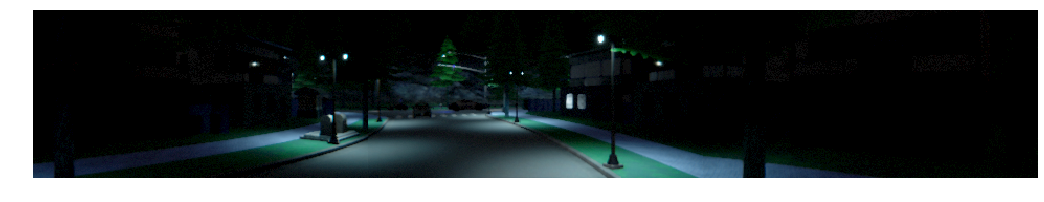

In [8]:
# load RGB image, scale to resolution, change to (C, H, W) format
rgb_image = cv2.imread(str(train_set.images[index], encoding='utf-8'), cv2.IMREAD_COLOR)
print(rgb_image.shape)

plt.figure(figsize=(18, 8))
plt.imshow(rgb_image);
plt.axis('off');

Unique values are [  0 128 192]
(2, 500, 500)


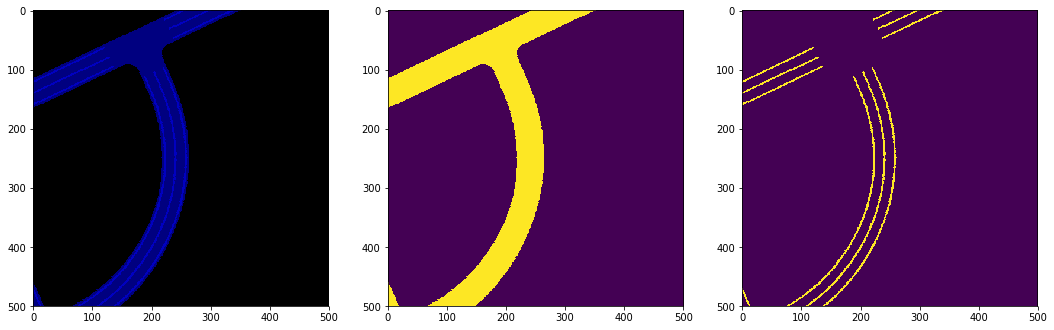

In [27]:
# BEV image -> load, decode, crop 
bev_array = cv2.imread(str(train_set.bevs[index], encoding='utf-8'), cv2.IMREAD_UNCHANGED)
bev_array = cv2.cvtColor(bev_array, cv2.COLOR_BGR2RGB)
print(f"Unique values are {np.unique(bev_array)}")

bev_array = np.moveaxis(bev_array, -1, 0)

from data import decode_pil_to_npy
loaded_bevs = decode_pil_to_npy(bev_array).astype(np.uint8)
print(loaded_bevs.shape)

fig, ax  = plt.subplots(1,3, figsize=(18,6))
ax[0].imshow(np.moveaxis(bev_array, 0, 2));
ax[1].imshow(loaded_bevs[0]);
ax[2].imshow(loaded_bevs[1]);

In [31]:
from data import load_crop_bev_npy
bev = load_crop_bev_npy(loaded_bevs, degree=0)
print(f"Cropped bev shape = {bev.shape}, unique values = {np.unique(bev)}, dtype = {bev.dtype}")

Cropped bev shape = (160, 160), unique values = [0 1 2], dtype = int64


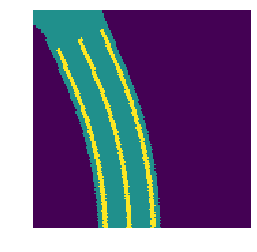

In [33]:
plt.imshow(bev)
plt.axis('off');

depth_image shape = (160, 704), dtype = float64


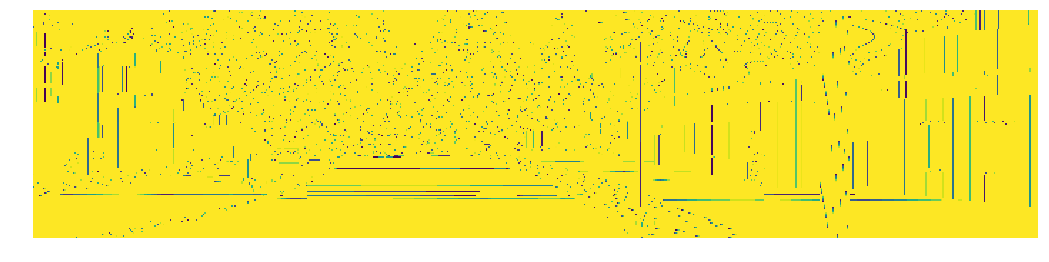

In [46]:
from data import get_depth

# Depth image
depth_image = cv2.imread(str(train_set.depths[index], encoding='utf-8'), cv2.IMREAD_COLOR)
depth_image = get_depth(crop_image_cv2(depth_image, crop=train_set.img_resolution, crop_shift=0))
print(f"depth_image shape = {depth_image.shape}, dtype = {depth_image.dtype}")

plt.figure(figsize=(18, 8))
plt.imshow(depth_image);
plt.axis('off');

semantic_image shape = (160, 704), dtype = uint8


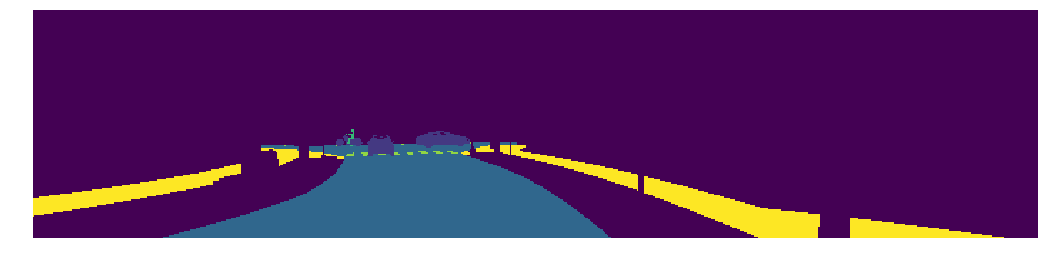

In [49]:
from data import crop_seg

# Semantic segmented image
semantic_image = cv2.imread(str(train_set.semantics[index], encoding='utf-8'), cv2.IMREAD_UNCHANGED)
semantic_image = train_set.converter[crop_seg(semantic_image, crop=train_set.img_resolution, crop_shift=0)]
print(f"semantic_image shape = {semantic_image.shape}, dtype = {semantic_image.dtype}")

plt.figure(figsize=(18, 8))
plt.imshow(semantic_image);
plt.axis('off');

## Measurements

In [50]:
# vehicle measurements
with open(str(train_set.measurements[index], encoding='utf-8'), 'r') as f1:
    measurements = ujson.load(f1)

data = {}
for k in ['steer', 'throttle', 'brake', 'speed', 'theta', 'x_command', 'y_command']:
    data[k] = measurements[k]
data['light'] = measurements['light_hazard']

In [51]:
data

{'steer': -0.035,
 'throttle': 0.75,
 'brake': False,
 'speed': 5.313167330369086e-07,
 'theta': 3.588655948638916,
 'x_command': 182.82735612929912,
 'y_command': 127.77637499105138,
 'light': False}

In [59]:
# target points
# convert x_command, y_command to local coordinates
# taken from LBC code (uses 90+theta instead of theta)
ego_theta = measurements['theta']
ego_x = measurements['x']
ego_y = measurements['y']
x_command = measurements['x_command']
y_command = measurements['y_command']

R = np.array([
    [np.cos(np.pi/2+ego_theta), -np.sin(np.pi/2+ego_theta)],
    [np.sin(np.pi/2+ego_theta),  np.cos(np.pi/2+ego_theta)]
    ])
local_command_point = np.array([x_command-ego_x, y_command-ego_y])
local_command_point = R.T.dot(local_command_point)

print(f"ego_x = {ego_x : .3f}, ego_y = {ego_y: .3f}, x_command = {x_command: .3f}, y_command = {y_command: .3f}")
print(f"local_command_point = {local_command_point}")

ego_x =  212.865, ego_y =  134.020, x_command =  182.827, y_command =  127.776
local_command_point = [ -7.35583993 -29.78525283]


(1, 256, 256)


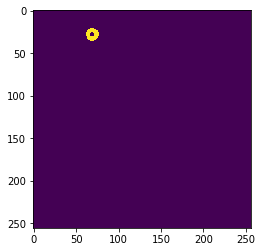

In [63]:
from data import draw_target_point

tgt_pt_in_lidar = draw_target_point(local_command_point)
print(tgt_pt_in_lidar.shape)
plt.imshow(tgt_pt_in_lidar[0]);

In [67]:
# load point cloud (XYZI), flip y-axis
# align to previous data, compute Lidar BEV features
lidars_pc = np.load(str(train_set.lidars[index], encoding='utf-8'), allow_pickle=True)[1] 
lidars_pc[:, 1] *= -1
print(lidars_pc.shape)

from data import align, lidar_to_histogram_features
lidars_pc = align(lidars_pc, measurements, measurements, degree=0)
lidars_pc = lidar_to_histogram_features(lidars_pc)

(32377, 4)


In [68]:
lidars_pc.shape

(2, 256, 256)

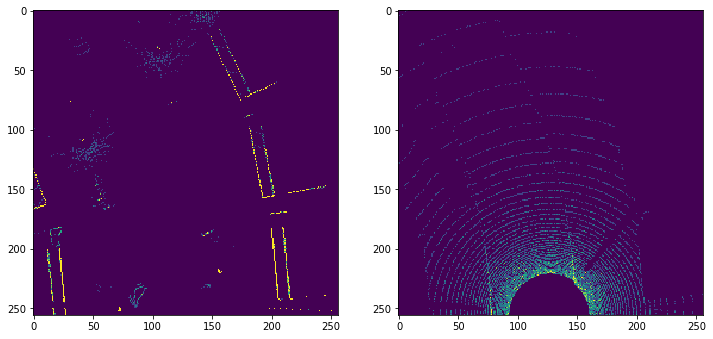

In [69]:
fig, ax  = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(lidars_pc[0]);
ax[1].imshow(lidars_pc[1]);